<h2 align=left> TensorFlow Hub İle NLP İçin Transfer Learning</h2>

---

In [19]:
!nvidia-smi

Mon Jan 30 07:21:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Gerekli kütüphaneleri import ediyoruz.

In [20]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

  Preparing metadata (setup.py) ... done
Version:  2.9.2
Hub version:  0.12.0
GPU is available


## The Quora Insincere Questions Datasetini indirip içeri aktaralım.



1.   https://www.kaggle.com/c/quora-insincere-questions-classification/data
2.   https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip
3.   https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip

In [21]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression='zip', low_memory=False)

df.shape

(1306122, 3)

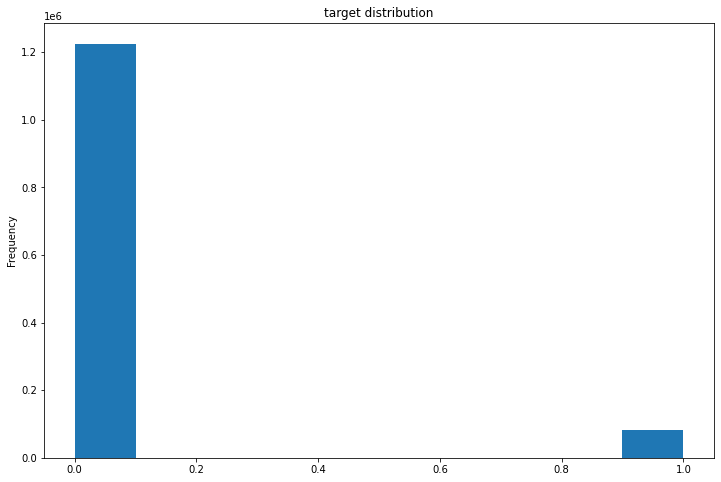

In [22]:
df['target'].plot(kind='hist', title = 'target distribution');

In [23]:
from sklearn.model_selection import train_test_split
train_df, remaining = train_test_split(df, random_state = 42, train_size=0.01, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size = 0.001, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((13061, 3), (1293, 3))

In [24]:
train_df.target.head(15).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [25]:
train_df.question_text.head(15).values

array(['What is your experience living in Venezuela in the current crisis? (2018)',
       'In which state/city the price of property is highest?',
       'Do rich blacks also call poor whites, “White Trash”?',
       'Should my 5 yr old son and 2 yr old daughter spend the summer with their father, after a domestic violent relationship?',
       'Why do we have parents?',
       'Do we experience ghost like Murphy did in Interstellar?',
       'Are Estoniano women beautiful?',
       'There was a Funny or Die video called Sensitivity Hoedown that got pulled. Does anyone know why?',
       'Is it a good idea to go in fully mainstream classes, even if I have meltdowns that might disrupt people?',
       'What classifies a third world country as such?',
       'Is being a pilot safe?',
       'Who is Illiteratendra Modi? Why does he keep with him a Rs 1 lakh pen?',
       'Have modern management strategies such as Total supply Chain Management applied to education? Can they be?',
       '

## Natural Language Processing için tensorflow hub


Metin verilerimiz sorulardan ve ilgili etiketlerden oluşur.

Bir soru vektörünü, bir sorunun dağıtılmış bir temsili olarak düşünebilirsiniz ve eğitim setindeki her soru için hesaplanır. Çıktı etiketi ile birlikte soru vektörü daha sonra istatistiksel sınıflandırma modelini eğitmek için kullanılır. 

Sezgi, soru vektörünün sorunun anlambilimini yakalaması ve sonuç olarak sınıflandırma için etkili bir şekilde kullanılabilmesidir.

Soru vektörlerini elde etmek için nlp'de çeşitli metin sınıflandırma problemlerinde kullanılan iki alternatifimiz var: 
* kelime tabanlı temsiller ve 
* içeriğe dayalı temsiller

#### Kelime Tabanlı Temsiller

- Bir sorunun ** kelime tabanlı gösterimi **, sorudaki içerik kelimelerinin kelime yerleştirmelerini birleştirir. Sorudaki içerik kelimelerinin kelime yerleştirmelerinin ortalamasını kullanabiliriz. Farklı NLP görevleri için kelime yerleştirmelerinin ortalaması kullanılmıştır.

- Önceden eğitilmiş gömme örnekleri şunları içerir:
  - **Word2Vec**: Bunlar, büyük bir metin şirketinden öğrenilen kelimelerin önceden eğitilmiş yerleştirmeleridir. Word2Vec, 300 milyon kelimeli bir haber makaleleri topluluğu üzerinde önceden eğitildi ve 300 boyutlu vektörlerle sonuçlandı.
  - **GloVe**: 200 boyutlu vektörlerle sonuçlanan 27 milyar kelimeli bir tweet topluluğu üzerinde önceden eğitilmiştir.


#### İçeriğe Dayalı Temsiller

- İçeriğe dayalı temsiller,cümle vektörleri oluşturmak için dil modellerini kullanabilir. Bu nedenle, cümledeki tek tek kelimeler için vektörleri öğrenmek yerine, kelimelerin sırasını ve birlikte oluşan kelimeler kümesini dikkate alarak genel olarak cümleler için bir vektör hesaplarlar.
- Derin bağlamsallaştırılmış vektörlerin örnekleri şunları içerir:
  - **Embeddings from Language Models (ELMo)**: karakter tabanlı sözcük temsillerini ve çift yönlü lstm'leri kullanır. Önceden eğitilmiş model, 1024 boyutlu bağlamsallaştırılmış bir vektör hesaplar. ELMo, Tensorflow Hub'da mevcuttur.
  - **Universal Sentence Encoder (USE)**: Kodlayıcı, kelimelerin sırası ve toplanması hakkında bilgi eklemek için dikkat mekanizmasını kullanan bir Transformatör mimarisi kullanır. 512 boyutlu bir vektör döndüren önceden eğitilmiş KULLANIM modeli, Tensorflow Hub'da da mevcuttur.
  - **Neural-Net Language Model (NNLM)**: Model, kelime dizileri için kelimelerin ve olasılık fonksiyonlarının temsillerini eşzamanlı olarak öğrenerek bir cümlenin anlambilimini yakalamasına olanak tanır. Tensorflow Hub'da bulunan, ingilizce Google Haberler 200B külliyatında eğitilmiş ve daha büyük model için 128 boyut ve daha küçük model için 50 boyuttan oluşan bir vektör hesaplayan önceden eğitilmiş modeller kullanacağız.


In [26]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

## Modelleri ve compiler'ı oluşturalım.

In [27]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)
  model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(256, activation = 'relu'),
                                      tf.keras.layers.Dense(64, activation = 'relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.losses.BinaryCrossentropy(),
                metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])
  history = model.fit(train_df['question_text'], train_df['target'],
                      epochs = 100, 
                      batch_size = 32,
                      validation_data = (valid_df['question_text'], valid_df['target']),
                      callbacks=[tfdocs.modeling.EpochDots(),
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                 tf.keras.callbacks.TensorBoard(logdir/name)],
                      verbose=0)
  return history

## Çeşitli Metin Sınıflandırma Modellerini Eğitelim.

In [28]:
histories = {}

Not: Birden fazla tensorflow hub modelimiz mevcut. Listeden seçim yaptıktan sonra histories dict'ini ve name kısmını seçilen modele göre güncellemeyi unutmayınız.
Ayrıca train_and_evaluate_model() fonksiyonundaki embed_size parametresini de seçtiğiniz modelin embed_size değeri ile güncellemeyi de unutmayınız.

In [41]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [42]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model(module_url,embed_size=512, name = 'universal-sentence-encoder-large',
                                                                    trainable=False)


Epoch: 0, accuracy:0.9214,  loss:0.3310,  val_accuracy:0.9381,  val_loss:0.1740,  
..............

## Doğruluk ve Kaybı görselleştirelim.

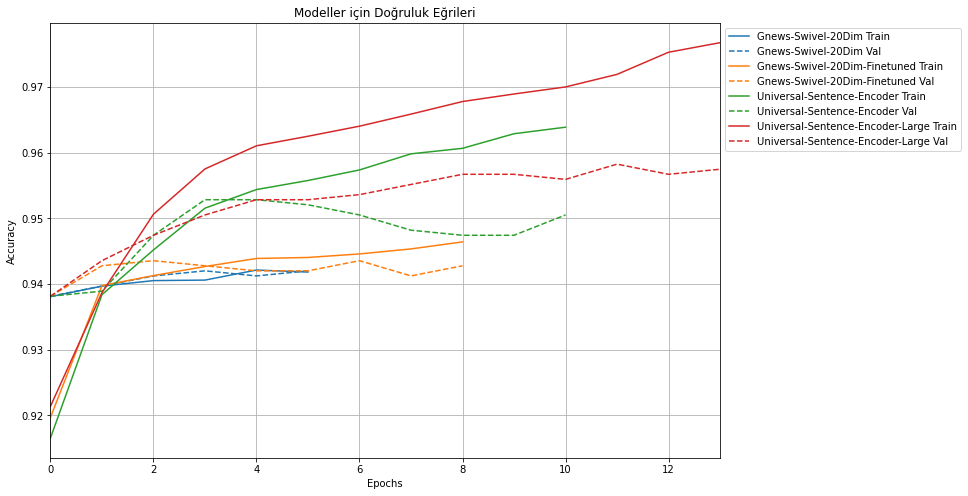

In [43]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Modeller için Doğruluk Eğrileri")
plt.show()

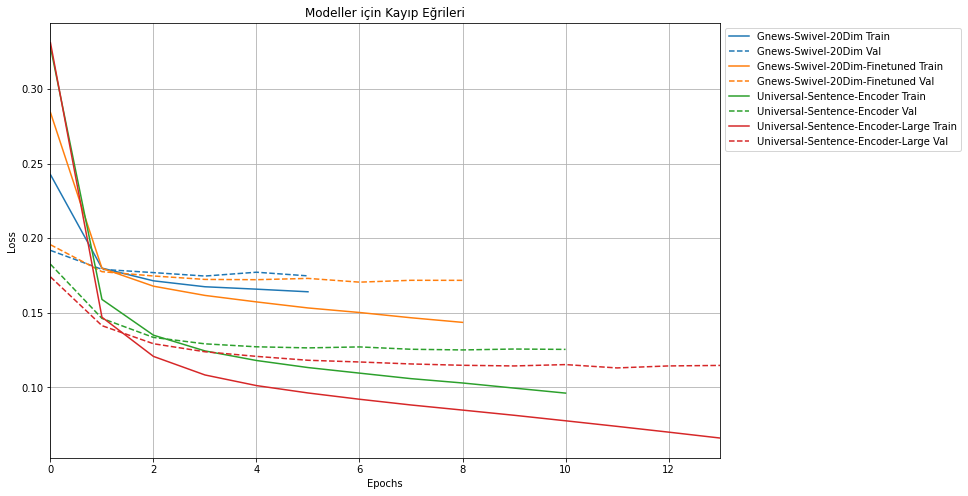

In [44]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Modeller için Kayıp Eğrileri")
plt.show()

## TF Hub Modelleri için fine-tune

In [36]:
# modelimize trainable=True parametresini ekledik. ve model ismini değiştirdik. acc ve loss çıktıları yukarıdaki görseldedir.
# görsel incelendiğinde acc ve loss değerlerinde olumlu yönde değişiklikler mevcuttur.

## TensorBoard ile Daha Büyük Modeller Eğitelim ve Metrikleri Görselleştirelim.

In [ ]:
%load_ext tensorboard

%tensorboard --logdir {logdir}